# 1. Instantiate GPU & Load Dataset
Environment Setup

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

Load Dataset

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='test.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Accelerator and wandb

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "test1-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Formatting Prompts

In [ ]:
def formatting_func(example):
  text = f"### 問題： {example['input']}\n ### 回覆: {example['output']}"
  return text

# 2. Load Base Model
Prepare Hugging Face API Key

In [ ]:
import os
os.environ["HF_HOME"] = ""
os.environ["HF_TOKEN"] = ""

# Load Base Model

We use MediaTek-Research/Breeze-7B-Base-v1_0 as the base model. It is a model which really supports zh-TW. Also, the version "base" is support for fine-tuning.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "MediaTek-Research/Breeze-7B-Base-v1_0"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.60G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/508M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

# 3. Tokenization

We use MediaTek-Research/Breeze-7B-Base-v1_0 as the tokenizer. It is a model which really supports zh-TW.

In [ ]:
tokenizer_id = "MediaTek-Research/Breeze-7B-Base-v1_0"
tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/911k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/238 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

298


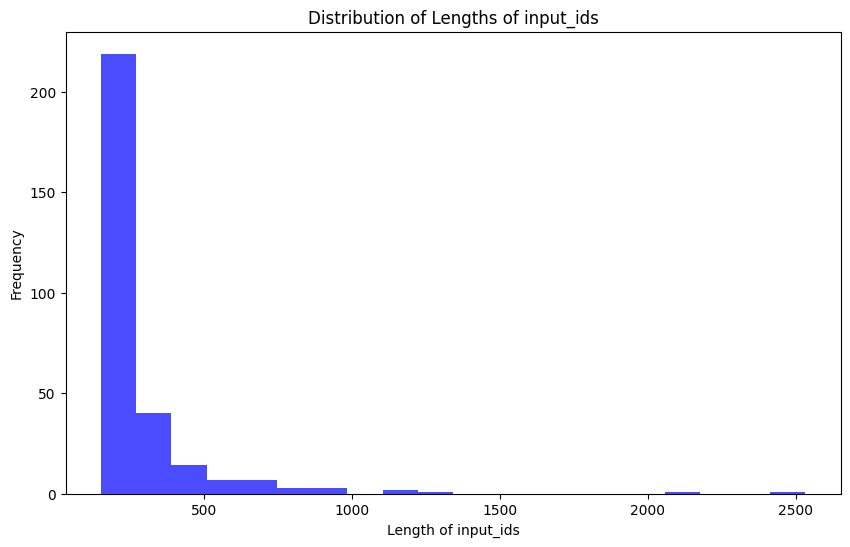

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
max_length = 500

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/238 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

# Check tokenization

In [ ]:
print(tokenized_train_dataset[1]['input_ids'])

[61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875, 61875

298


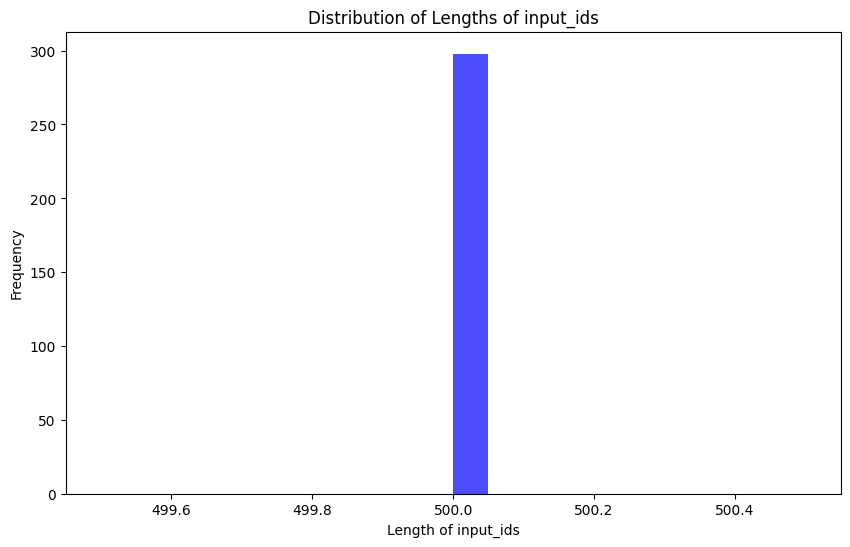

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

# Test Base Model

In [ ]:
eval_prompt = "我想要知道關於下面這首詩的資訊，「北山白雲裡，隱者自怡悅。相望始登高，心隨雁飛滅。愁因薄暮起，興是清秋發。時見歸村人，沙行渡頭歇。天邊樹若薺，江畔洲如月。何當載酒來，共醉重陽節。」"

# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=False,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


我想要知道關於下面這首詩的資訊，「北山白雲裡，隱者自怡悅。相望始登高，心隨雁飛滅。愁因薄暮起，興是清秋發。時見歸村人，沙行渡頭歇。天邊樹若薺，江畔洲如月。何當載酒來，共醉重陽節。」
※ 1.這是什麼樣的一首詩？
2.作者是誰？
3.寫於何時？
4.內容大意為何？
5.有沒有其他相關資料可以提供給我參考呢？
6.如果您覺得我的問題很好，請幫我打分數喔！謝謝！
7.如果您覺得我的問題不好，麻煩請您告訴我哪裡不好，我會改進的！謝謝！
8.如果您覺得我的問題很爛，麻煩請您告訴我為什麼這麼爛，我會改進的！謝謝！
9.如果您覺得我的問題很棒，麻煩請您告訴我為什麼這麼棒，我會繼續努力的！謝謝！
10.如果您覺得我的問題還可以更好，麻煩請您告訴我如何才能更好，我會繼續努力的！謝謝！
11.如果您覺得我的問題不錯，麻煩請您告訴我為什麼這樣說，我會繼續努力的！謝謝！
12.如果您覺得我的問題還不錯，麻煩請您告訴我為什麼這樣說，我會繼續努力的！謝謝！
13.如果您覺得我的問題還OK，麻煩請您告訴我為什麼這樣說，我會繼續努力的！謝謝！
14.如果您


In [ ]:
tokenizer_id = "MediaTek-Research/Breeze-7B-Base-v1_0"

# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_id,
    add_bos_token=False,
)

# Assuming `eval_prompt` is defined elsewhere in your code
model_input = eval_tokenizer(eval_prompt, return_tensors="pt")

# Remove 'token_type_ids' if not needed by the model
if 'token_type_ids' in model_input:
    del model_input['token_type_ids']

model_input = model_input.to("cuda")

model.eval()
with torch.no_grad():
    generated_tokens = model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)
    print(eval_tokenizer.decode(generated_tokens[0], skip_special_tokens=True))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


我想要知道關於下面這首詩的資訊，「北山白雲裡，隱者自怡悅。相望始登高，心隨雁飛滅。愁因薄暮起，興是清秋發。時見歸村人，沙行渡頭歇。天邊樹若薺，江畔洲如月。何當載酒來，共醉重陽節。」
※ 1.這是什麼樣的一首詩？
2.作者是誰？
3.寫於何時？
4.內容大意為何？
5.有沒有其他相關資料可以提供給我參考呢？
6.如果您覺得我的問題很好，請幫我打分數喔！謝謝！
7.如果您覺得我的問題不好，麻煩請您告訴我哪裡不好，我會改進的！謝謝！
8.如果您覺得我的問題很爛，麻煩請您告訴我為什麼這麼爛，我會改進的！謝謝！
9.如果您覺得我的問題很棒，麻煩請您告訴我為什麼這麼棒，我會繼續努力的！謝謝！
10.如果您覺得我的問題還可以更好，麻煩請您告訴我如何才能更好，我會繼續努力的！謝謝！
11.如果您覺得我的問題不錯，麻煩請您告訴我為什麼這樣說，我會繼續努力的！謝謝！
12.如果您覺得我的問題還不錯，麻煩請您告訴我為什麼這樣說，我會繼續努力的！謝謝！
13.如果您覺得我的問題還OK，麻煩請您告訴我為什麼這樣說，我會繼續努力的！謝謝！
14.如果您


# 4. Set Up LoRA

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(61952, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85999616 || all params: 4083437568 || trainable%: 2.1060592838234866


# 5. Run Training

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
import transformers
from datetime import datetime

project = "test1-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=100,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=False,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


wandb: Currently logged in as: 40802001e (kkaren). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,3.309500,2.273039
50,2.929900,2.143851
75,2.893300,2.105297
100,2.852800,2.094919


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To main

TrainOutput(global_step=100, training_loss=2.9963775634765626, metrics={'train_runtime': 2915.9206, 'train_samples_per_second': 0.069, 'train_steps_per_second': 0.034, 'total_flos': 4391605862400000.0, 'train_loss': 2.9963775634765626, 'epoch': 0.8403361344537815})

# 6. Try the Trained Model!

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "MediaTek-Research/Breeze-7B-Base-v1_0"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-test1-finetune/checkpoint-100")

NameError: name 'base_model' is not defined

In [ ]:
eval_prompt = "我想要知道關於下面這首詩的資訊，「北山白雲裡，隱者自怡悅。相望始登高，心隨雁飛滅。愁因薄暮起，興是清秋發。時見歸村人，沙行渡頭歇。天邊樹若薺，江畔洲如月。何當載酒來，共醉重陽節。」"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


我想要知道關於下面這首詩的資訊，「北山白雲裡，隱者自怡悅。相望始登高，心隨雁飛滅。愁因薄暮起，興是清秋發。時見歸村人，沙行渡頭歇。天邊樹若薺，江畔洲如月。何當載酒來，共醉重陽節。」
※ 1.這是什麼樣的一首詩？
2.作者是誰？
3.寫於何時？
4.內容大意為何？
5.有沒有其他相關資料可以提供給我參考呢？
6.如果您覺得我的問題很好，請幫我打分數喔！謝謝！
7.如果您覺得我的問題不好，麻煩請您告訴我哪裡不好，我會改進的！謝謝！
8.如果您覺得我的問題很爛，麻煩請您告訴我為什麼這麼爛，我會改進的！謝謝！
9.如果您覺得我的問題很棒，麻煩請您告訴我為什麼這麼棒，我會繼續努力的！謝謝！
10.如果您覺得我的問題還可以更好，麻煩請您告訴我如何才能更好，我會繼續努力的！謝謝！
11.如果您覺得我的問題不錯，麻煩請您告訴我為什麼這樣說，我會繼續努力的！謝謝！
12.如果您覺得我的問題還不錯，麻煩請您告訴我為什麼這樣說，我會繼續努力的！謝謝！
13.如果您覺得我的問題還OK，麻煩請您告訴我為什麼這樣說，我會繼續努力的！謝謝！
14.如果您覺得我的問題還可以更好，麻煩請您告訴我如何才能更好，我會繼續努力的！謝謝！
15.如果您覺得我的問題不錯，麻煩請您告訴我為什麼這樣說，我會繼續
